# Exemplo de Regressão Logística usando Softmax (Iris dataset) implementação matricial

Utiliza uma rede neural de uma camada e função Softmax. A programação da rede, assim
como o seu treinamento e predição utilizam programação matricial, sem fazer uso de
bibliotecas de *machine learning*.

O uso de apenas dois atributos permite visualização do espaço de atributos


### Este tutorial foi inspirado na documentação do sklearn : [Logistic Regression 3-class Classifier](http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py)

Objetivo deste exemplo é codificar o método de Regressão Logística utilizando Softmax e
gradiente descendente. As bibliotecas usadas são mínimas, principalmente as funções básicas
matriciais dos pacotes `NumPy` e `Scipy`. As demais bibliotecas são usadas neste exemplo apenas para: `pandas` - para imprimir a matriz de confusão; `sklearn` - para carregar o conjunto de
dados Iris; `matplotlib` - para mostrar gráfico e imagens.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline


## Iris Flower Dataset

[Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set): The data set consists of 50 samples from each of three species of Iris (*Iris setosa, Iris virginica and Iris versicolor*). Four features were measured from each sample: the **length and the width of the sepals and petals, in centimetres**. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

### Escolhendo os dois atributos

![](../figures/iris_petals_sepals.png)

Dos 4 atributos disponíveis: comprimento e largura das sépalas e comprimento e largura das pétalas, vamos escolher o comprimento das sépalas e comprimento das pétalas. Isto é feito
escolhendo os atributos de índice 0 e 2 dos dados da íris:

In [41]:
from sklearn import linear_model, datasets

iris = datasets.load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
X = np.hstack([np.ones((150,1)),X]) # incluído X00 como 1 para gerar bias no W
Y = iris.target



### Visualizando o dataset

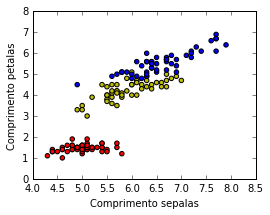

In [42]:
plt.figure(1, figsize=(4, 3))
colors = np.array(['r','y','b'])
plt.scatter(X[:, 1], X[:, 2], c=colors[Y])
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

### Função para codificar rótulos inteiros na codificação one-hot

Esta função é também chamada de conversão para dados categóricos. Temos 3 classes de
flores: Iris setosa, Iris virginica and Iris versicolor. Estas classes podem ser codificadas
como classes 0, 1 e 2 (rótulos numéricos) ou na codificação com 3 variáveis binárias:

<table border="1">
<tr>
<td>Espécie</td>
<td>Y</td>
<td>Y_oh[0]</td>
<td>Y_oh[1]</td>
<td>Y_oh[2]</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>0</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>1</td>
<td>0</td>
<td>1</td>
<td>0</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>2</td>
<td>1</td>
<td>0</td>
<td>1</td>
</tr>
</table>



A função `oneHotIt` a seguir implementa de forma eficiente esta conversão, utilizando a
facilidade de criação de arrays esparsos.

A entrada da função é o vetor `Y` e a saída será um array com o mesmo número de
linhas que o número de elementos de `Y` e a largura terá o número de colunas do
maior rótulo disponível em `Y`:


In [43]:
def oneHotIt(Y,k):
    Y = Y.reshape(-1,1)
    i = np.arange(k).reshape(1,k)
    Y_oh = (Y == i).astype(int)
    return Y_oh
    

Gerando vetor de rótulos no formato one-hot 

In [44]:
Y_oh = oneHotIt(Y,3)
# Mostrando os primeiros 5 destes valores
print 'Y:\n', Y[:5]
print 'Y_oh[:5]=\n',Y_oh[:5]

Y:
[0 0 0 0 0]
Y_oh[:5]=
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


Now we set the loaded data as our x and y variables for both the train and test sets.

![](../figures/w0bias.png)
![](https://sebastianraschka.com/images/faq/softmax_regression/logistic_regression_schematic.png)



A funcão Softmax já foi vista antes:
Recebe como entrada uma matriz bidimensional, nas $n$ linhas são as amostras e nas $k$ colunas são os *scores* de cada amostra.
No resultado, a matriz também é bidimensional, com as mesmas dimensões da matriz de *scores* de entrada, entretanto, a soma de cada linha referente à amostra $i$ é 1, pois cada coluna
representa a probabilidade dessa amostra cada a classe $k$. 

Revisando, a implementação matricial usando o NumPy é baseado na equação matricial, repetida aqui:

$$ Softmax(\boldsymbol{Z}) = \frac{e^{\boldsymbol{Z}}}{\sum_{j=0}^{k-1}e^{z_{i,j}}} $$

## Função `softmax`

In [45]:
def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True) # normaliza nas classes - colunas
    return S

## Função `predict`

A função predict escolhe a classe de maior probabilidade.
Entrada:
- X: matriz bidimensional (n,m): n amostras e m attributes - AMOSTRAS
- W: matriz bidimensional (m,k): m attributes e k classes - PESOS TREINADOS
Saída:
- Y_hat: matriz bidimensional (n,1): n amostras x 1 - CLASSE prevista


In [46]:
def predict(X,W):
    S = softmax(X.dot(W))
    # escolhe a maior probabilidade entre as classes
    Y_hat = np.argmax(S,axis=1) # mantém o resultado como matriz bidimensional
    return Y_hat

### Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

A função a ser minimizada é a função $J$ de perda, que é baseada na Entropia Cruzada (*Cross Entropy*). Dado um conjunto de **amostras anotadas**, isto é, amostras $\boldsymbol{X}$ com
classe $\boldsymbol{Y}$, encontrar os pesos $\boldsymbol{W}$ que minimizam $J$:

$$ J_{\boldsymbol{X,Y}_{TRUE}}(\boldsymbol{W}) = -\frac{1}{n} \sum \boldsymbol{Y}_{TRUE} \odot \log{\boldsymbol{S}(\boldsymbol{XW})}$$
onde $\odot$ é multiplicação ponto-a-ponto de matrizes.

A minimização é feita através do método de gradiente descendente. O gradiente de $J$ é dado por:

$$ \boldsymbol{\Delta J(W)} = - \frac{1}{n} \boldsymbol{X}^T (\boldsymbol{Y}_{TRUE} - \boldsymbol{S(XW)}) $$ 

Os pesos são então ajustados em cada *batch* pela equação onde $\eta$ é denominado de
taxa de aprendizagem: *learning rate*:

$$ \boldsymbol{W} = \boldsymbol{W} - \eta \boldsymbol{\Delta J(W)} $$ 

A cada iteração no programa de minimização abaixo, os pesos são ajustados aplicando-se o
gradiente descendente utilizando todo o conjunto de treinamento. Este esquema é denominado
de "batch gradient descent".

No programa a seguir, o $J$ é implementado pela variável `loss` e o gradiente $\Delta J$ 
é implementado pela variável `Grad`.

W: [[ 1.52460768  5.61473112 -7.1393388 ]
 [ 4.11741611 -0.12543194 -3.99198417]
 [-7.10287364 -0.22131854  7.32419219]]
S.shape: (150, 3)
loss.shape: ()
Grad.shape: (3, 3)
W.shape: (3, 3)
Final loss: 0.10747711677


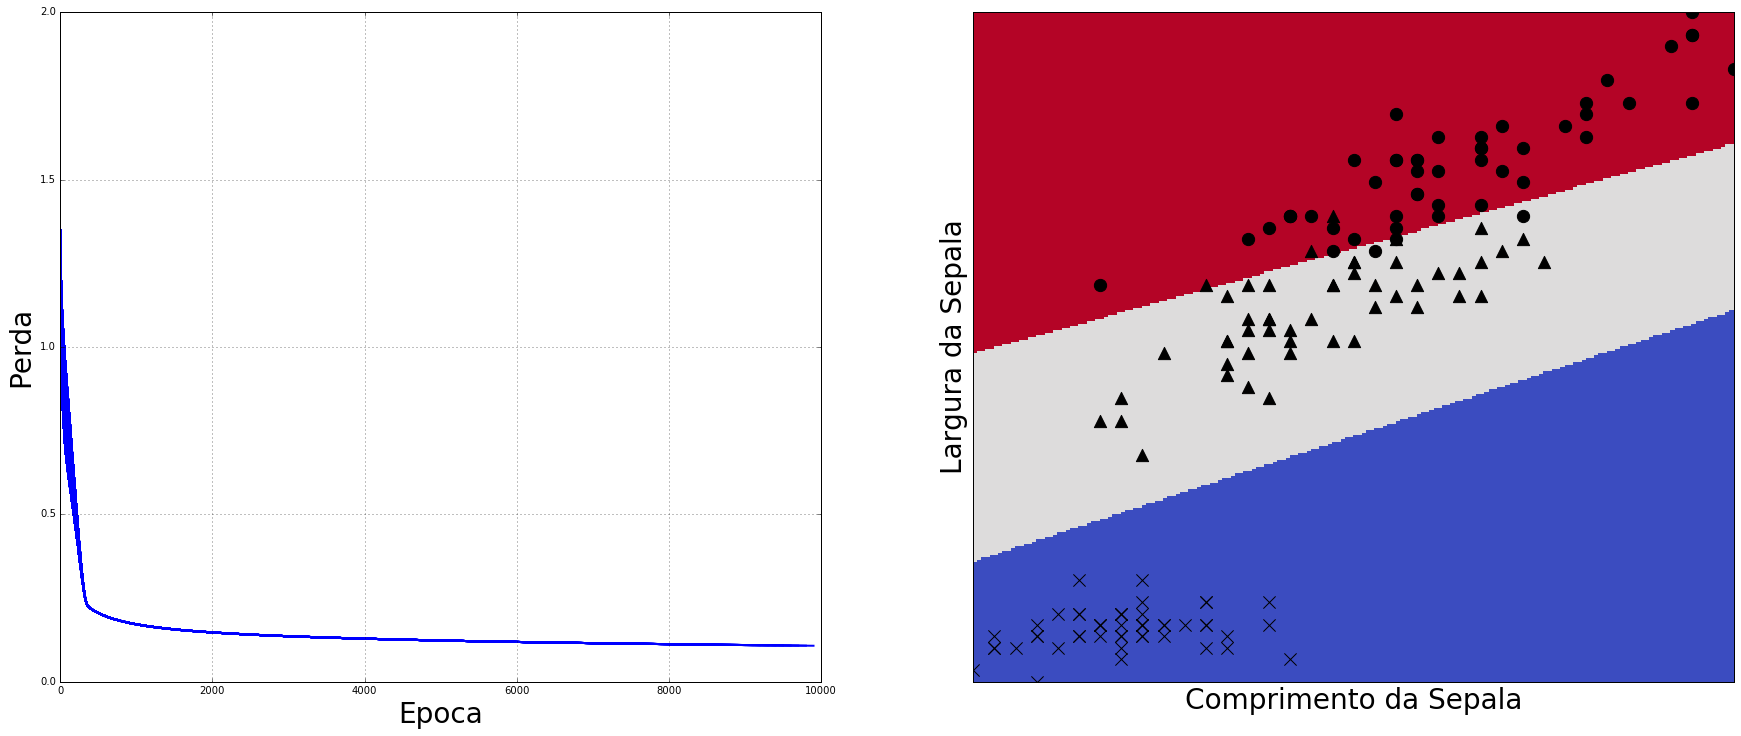

In [48]:
n = X.shape[0] # number of training examples
m = X.shape[1] # number of attributes (features + 1(bias))
k = 3          # number of classes

W = np.zeros([m,k]) # n. de linhas é igual a número de atributos (features, pixels)
print 'W.shape:', W.shape
print 'n:',n
lam = 0 # 1 sem regularização
iterations = 10000
learningRate = 1e-3 * 150
losses = []

#Gráficos a serem mostrados pelo callback
h = 0.02
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, iterations)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.grid(True)
plt.subplot(122)
plt.xlim(X[:,1].min(), X[:,1].max())
plt.ylim(X[:,2].min(), X[:,2].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)
plt.xticks(())
plt.yticks(())
plot_frequency  = 100
x_min, x_max = X[:, 1].min() - .5, X[:, 1].max() + .5
y_min, y_max = X[:, 2].min() - .5, X[:, 2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


for i in range(iterations):
    scores = X.dot(W)
    S = softmax(scores)
    loss = (-1. / n) * np.sum(Y_oh * np.log(S)) + (lam/2) * (W*W).sum() 
    Grad = (-1. / n) * (X.T).dot(Y_oh - S) + lam*W 
    W = W - (learningRate * Grad)
    losses.append(loss)
    if i%plot_frequency == 0:
        plt.subplot(121)
        plt.plot(np.arange(i+1),losses,'b',linewidth = 2.0)
        plt.subplot(122)
        X_grid = np.c_[xx.ravel(), yy.ravel()]
        X_grid = np.hstack([np.ones((X_grid.shape[0],1)),X_grid]) # incluído X00 como 1 para gerar bias no W
        Z = predict(X_grid, W)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(4, 3))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
        aux = Y == 0
        plt.scatter(X[aux, 1], X[aux, 2],s=150,c = 'black',marker = 'x')
        aux = Y == 1
        plt.scatter(X[aux, 1], X[aux, 2],s=150,c = 'black',marker = '^')
        aux = Y == 2
        plt.scatter(X[aux, 1], X[aux, 2],s=150,c = 'black',marker = 'o')
        display.display(plt.gcf())
        display.clear_output(wait=True)

    
    
print 'W:',W
print 'S.shape:', S.shape
print 'loss.shape:',loss.shape
print 'Grad.shape:',Grad.shape
print 'W.shape:',W.shape
print 'Final loss:',loss
# usual dar loss de 317.25

Após treinar o modelo, nós podemos ver como ele se porta nos conjuntos de treino:

In [ ]:
def getAccuracy(X,W, Y):
    Y_hat = predict(X,W)
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

print 'Training Accuracy: ', getAccuracy(X,W,Y)
